In [1]:
import matplotlib.pyplot as plt
import nolds
from nolitsa import delay, lyapunov
import numpy as np
from scipy.signal import argrelextrema
from scipy.spatial.distance import cdist
from scipy.stats import linregress
import statsmodels.api as sm
import sys
from tqdm.notebook import tqdm

sys.path.append("..")
from nld_utils import calculate_fnn_stat, embed_signal, get_metric, get_nn_indices

# Simulate Systems

### Simulating the Lorenz Attractor

The equations that govern the Lorenz attractor are:

$$\frac{dx}{dt} = \sigma(y - x)$$

$$\frac{dy}{dt} = x(\rho - z) - y$$

$$\frac{dz}{dt} = xy - \beta z$$

where we set $\beta = \frac{8}{3}$ and $\sigma = 10$ based on https://itp.uni-frankfurt.de/~gros/Vorlesungen/SO/simulation_example/.

In [2]:
# dt, T are in milliseconds
def simulate_lorenz(rho, beta=8/3, sigma=10, dt=0.0001, T = 2, initial_condition=None):
    if initial_condition is None:
        initial_condition = np.random.normal(size=(3,))
    
    time_vals = np.arange(0, T + dt, dt)
    pts = np.zeros((len(time_vals), 3))
    pts[0] = initial_condition
    
    for t in range(1, len(time_vals)):
        x, y, z = pts[t - 1]
        dx = sigma*(y - x)
        dy = x*(rho - z) - y
        dz = x*y - beta*z
        
        x += dx*dt
        y += dy*dt
        z += dz*dt
        
        pts[t] = [x, y, z]
    
    return pts, time_vals

In [3]:
dt = 0.01
T = 50
lorenz_pts, time_vals = simulate_lorenz(28, dt=dt, T=T, initial_condition=[0.62225717, -0.08232857, 30.60845379])

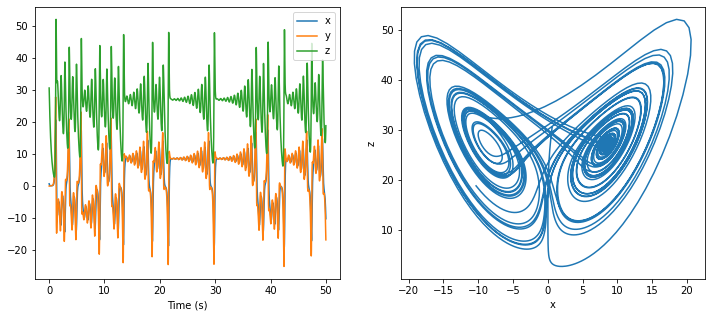

In [4]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(time_vals, lorenz_pts[:, 0], label='x')
plt.plot(time_vals, lorenz_pts[:, 1], label='y')
plt.plot(time_vals, lorenz_pts[:, 2], label='z')
plt.xlabel('Time (s)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lorenz_pts[:, 0], lorenz_pts[:, 2])
plt.xlabel('x')
plt.ylabel('z')

plt.show()

### Simulating Baier-Klein

In [5]:
# dt, T are in milliseconds
def simulate_baier_klein(T = 5000, initial_condition=None):
    if initial_condition is None:
        initial_condition = np.random.normal(size=(3,))
    
    time_vals = np.arange(0, T + 1)
    pts = np.zeros((len(time_vals), 3))
    pts[0] = initial_condition
    
    for t in range(1, len(time_vals)):
        x, y, z = pts[t - 1]
        x_new = 1.76 - y**2 - 0.1*z
        y_new = x
        z_new = y
        
        pts[t] = [x_new, y_new, z_new]
    
    return pts, time_vals

In [6]:
T = 3000
dt = 1
baier_klein_pts, time_vals = simulate_baier_klein(T=T, initial_condition=(0, 0, 0))

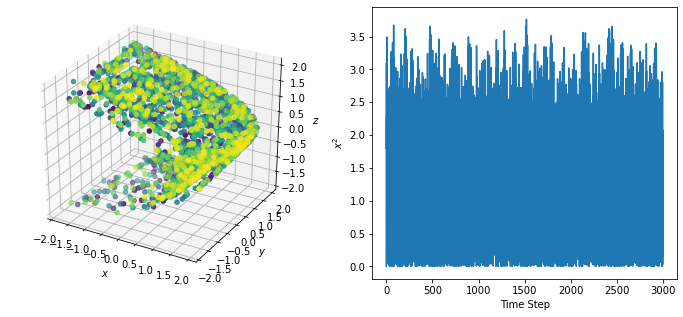

In [7]:
fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.scatter(baier_klein_pts[:, 0], baier_klein_pts[:, 1], baier_klein_pts[:, 2], c=time_vals)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

plt.subplot(1, 2, 2)
plt.plot(baier_klein_pts[:, 0]**2)
plt.xlabel('Time Step')
plt.ylabel('$x^2$')
plt.show()

plt.show()

# NLD Analysis

In [8]:
dt = 0.01 # s
T = 50 # s
lorenz_pts, time_vals = simulate_lorenz(28, dt=dt, T=T, initial_condition=[0.62225717, -0.08232857, 30.60845379])

# T = 3000 # s
# dt = 1 # s
# baier_klein_pts, time_vals = simulate_baier_klein(T=T, initial_condition=(0, 0, 0))

In [9]:
signal_in = lorenz_pts[:, 0]
# signal_in = baier_klein_pts[:, 0]**2

### 1. Pick $\tau$

#### Autocorrelation

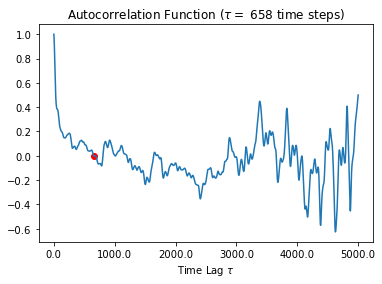

In [10]:
acf = sm.tsa.acf(signal_in, nlags=5000, adjusted='True', fft=False)
tau = np.argmax(acf < 0)

plt.plot(acf)
plt.title(fr'Autocorrelation Function ($\tau = $ {tau} time steps)')
plt.xlabel(r'Time Lag $\tau$')
xticks = plt.xticks()[0][1:-1]
plt.xticks(xticks, xticks)
plt.scatter(tau, 0, c='red')
plt.show()

#### Mutual Information

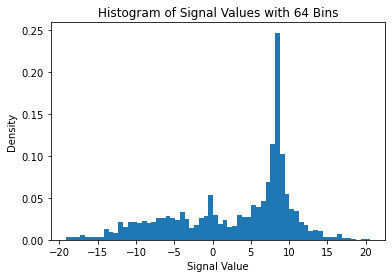

In [11]:
bins = 64 # nolitsa default is 64
plt.hist(signal_in, bins=bins, density=True)
plt.xlabel('Signal Value')
plt.ylabel('Density')
plt.title(f'Histogram of Signal Values with {bins} Bins')
plt.show()

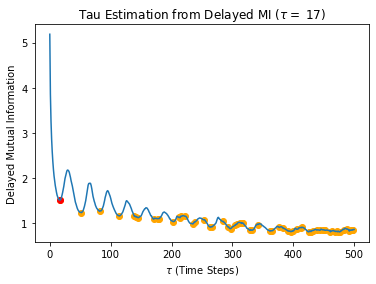

In [12]:
nlags = 500
delayed_mi = np.zeros(nlags + 1)

n = len(signal_in)
for tau in range(nlags + 1):
    delayed_mi[tau] = delay.mi(signal_in[tau:], signal_in[:n - tau], bins=bins)

local_min_locs = argrelextrema(delayed_mi, np.less) [0]   
tau = local_min_locs[0]

plt.plot(np.arange(nlags + 1), delayed_mi)
plt.scatter(local_min_locs, delayed_mi[local_min_locs], c='orange')
plt.scatter(tau, delayed_mi[tau], c='red') 
plt.xlabel(r'$\tau$ (Time Steps)')
plt.ylabel('Delayed Mutual Information')
plt.title(fr'Tau Estimation from Delayed MI ($\tau = $ {tau})')
plt.show()

### 2. Pick $m$

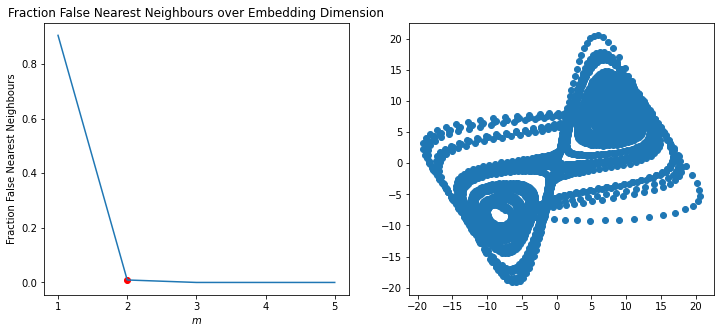

In [13]:
p = 1
r = 10

m_vals = np.arange(1, 6)
fraction_fnn = np.zeros(m_vals.shape)

for i, m in enumerate(m_vals):
    embedding = embed_signal(signal_in, m, tau=tau)
    nn_indices, _ = get_nn_indices(embedding, p=p)
    fraction_greater, ratios = calculate_fnn_stat(embedding, nn_indices, r, p=p)
    fraction_fnn[i] = fraction_greater

if sum(fraction_fnn < 0.1) > 0:
    m = np.argmax(fraction_fnn < 0.1) + 1
else:
    m = m_vals[-1]

# embed data
embedding = embed_signal(signal_in, m, tau=tau)

fig = plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(m_vals, fraction_fnn)
plt.scatter(m, fraction_fnn[m - 1], c='red')
plt.title('Fraction False Nearest Neighbours over Embedding Dimension')
plt.ylabel('Fraction False Nearest Neighbours')
plt.xlabel('$m$')
plt.xticks(m_vals, m_vals)

if m == 3:
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2])
elif m == 2:
    plt.subplot(1, 2, 2)
    plt.scatter(embedding[:, 0], embedding[:, 1])

plt.show()

### 3. Lyapunov Exponent

#### NoLiTSA

In [14]:
maxt = 100
theiler_window = 60

# use nolitsa to compute average divergence (average of log neighbor distance)
d = lyapunov.mle_embed(signal_in, dim=[m], tau=tau, maxt=maxt, window=theiler_window)[0]
t = np.arange(maxt)  # ms

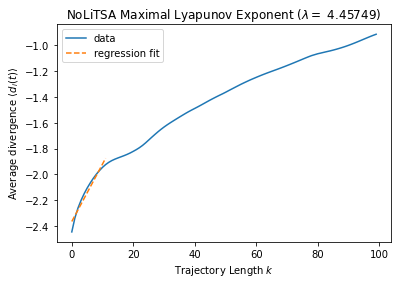

In [15]:
plt.plot(t, d, label='data')
plt.xlabel(r'Trajectory Length $k$')
plt.ylabel(r'Average divergence $\langle d_i(t) \rangle$')
start_linear = 0
end_linear = 12
slope, intercept, _, _, _ = linregress(dt*t[start_linear:end_linear], d[start_linear:end_linear])
plt.title(rf"NoLiTSA Maximal Lyapunov Exponent ($\lambda = $ {slope:.5f})")
plt.plot(t[start_linear:end_linear], slope*dt*t[start_linear:end_linear] + intercept, linestyle='--', label='regression fit')
plt.legend()
plt.show()

#### Nolds (Rosenstein)

In [20]:
le, (k_vals, d_vals, poly) = nolds.measures.lyap_r(signal_in, emb_dim=m, lag=tau, tau=dt, min_tsep=theiler_window, trajectory_len=250, debug_data=True)

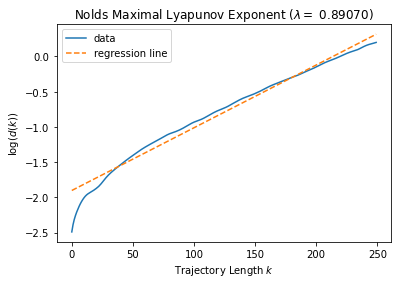

In [21]:
plt.plot(k_vals, d_vals, label='data')
plt.plot(k_vals, poly[0]*k_vals + poly[1], linestyle='--', c='C1', label='regression line')
plt.ylabel('log($d(k)$)')
plt.xlabel(r'Trajectory Length $k$')
plt.title(fr"Nolds Maximal Lyapunov Exponent ($\lambda = $ {le:.5f})")
plt.legend()
plt.show()

In [22]:
len(signal_in)

5001

#### My Code

In [323]:
def average_neighbor_distance(embedding, pairwise_dists, max_delta=30, num_reference_pts=100, min_tsep=60, progress_bar=False, iterator=None):
    S = np.zeros(max_delta + 1)
    N = len(embedding)
    if progress_bar:
        iterator = tqdm(total=np.sum((N - np.arange(max_delta+1))*(N - np.arange(max_delta+1))))
    
    if num_reference_pts is None:
        reference_indices = np.arange(N - max_delta)
    else:
        reference_indices = np.random.choice(np.arange(N - max_delta), size=(num_reference_pts,))
    
    counts = np.zeros(max_delta + 1)

    for i in reference_indices:
        pairwise_dists[i, i] = np.Inf
        pairwise_dists[i, max(0, i - min_tsep):min(i + min_tsep, N)] = np.Inf
        pairwise_dists[i, -(max_delta + 1):] = np.Inf
        nb_idx = np.argmin(pairwise_dists[i, :])
        
        for delta_n in range(max_delta + 1):
            traj_dist = pairwise_dists[i + delta_n, nb_idx + delta_n]
            if traj_dist != 0:
                S[delta_n] += np.log(traj_dist)
                counts[delta_n] += 1
        
        if iterator is not None:
            iterator.update()
        

    S = S/counts
    if iterator is not None and progress_bar:
        iterator.close()
    
    return S, np.arange(max_delta + 1)

def compute_average_neighbor_distance(signal, m_vals, max_delta=30, num_reference_pts=100, p=1, min_tsep=60, progress_bar=True):
    results = []
    total = 0
    if progress_bar:
        for m in m_vals:
            embedding = embed_signal(signal, m, tau=tau)
            N = len(embedding)
            if num_reference_pts is None:
                total += (N - max_delta)
            else:
                total += num_reference_pts
        iterator = tqdm(total = total)

    for m in m_vals:
        embedding = embed_signal(signal, m, tau=tau)
        pairwise_dists = cdist(embedding, embedding, metric=get_metric(p, name=True))
        if progress_bar:
            S, delta_n = average_neighbor_distance(embedding, pairwise_dists, max_delta=max_delta, num_reference_pts=num_reference_pts, min_tsep=min_tsep, progress_bar=False, iterator=iterator)
        else:
            S, delta_n = average_neighbor_distance(embedding, pairwise_dists, max_delta=max_delta, num_reference_pts=num_reference_pts, min_tsep=min_tsep)
        results.append(dict(
            m=m,
            S=S,
            delta_n=delta_n
        ))

    if progress_bar:
        iterator.close()
    
    return results

In [326]:
m_vals = [m]
max_delta = 1000
num_reference_pts = None
p = 1

results = compute_average_neighbor_distance(signal_in, m_vals, max_delta, num_reference_pts, p, min_tsep=theiler_window, progress_bar=True)

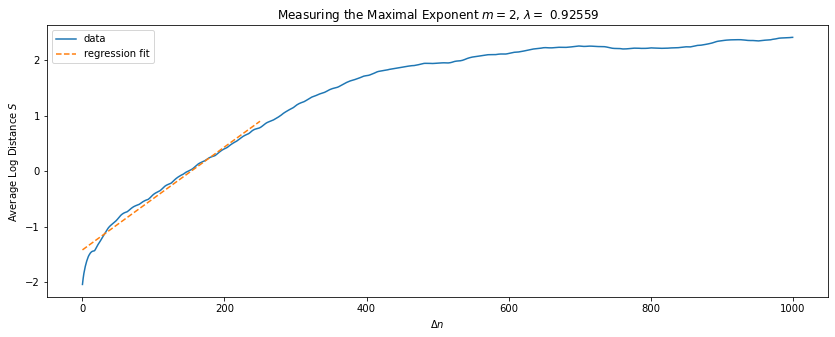

In [330]:
plt.figure(figsize=(14, 5))
for i, m in enumerate(m_vals):
    plt.subplot(1, len(m_vals), i + 1)
    end_linear = [250][i]
    lambdas = []
    for j, result in enumerate(results):
        if result['m'] == m:
            slope, intercept, _, _, _ = linregress(result['delta_n'][:end_linear + 1]*dt, result['S'][:end_linear + 1])
            plt.plot(result['delta_n'], result['S'], label='data', c=f"C0")
            plt.plot(result['delta_n'][:end_linear+1], result['delta_n'][:end_linear+1]*slope*dt + intercept, label='regression fit', linestyle='--', c=f"C1")
    plt.xlabel(r'$\Delta n$')
    plt.ylabel(r'Average Log Distance $S$')
    plt.title(rf"Measuring the Maximal Exponent" + f" $m =${m}, $\lambda = $ {slope:.5f}")
    plt.legend()

plt.show()

#### Nolds (Eckmann)

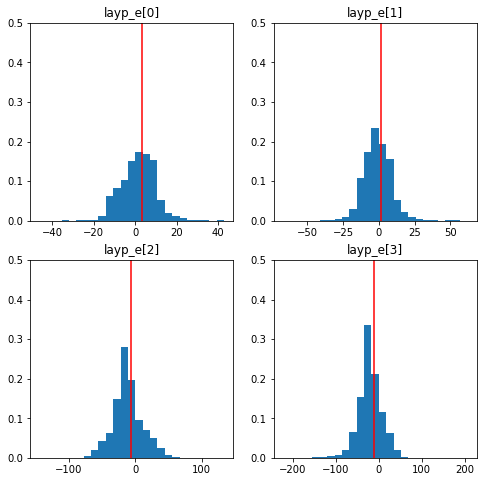

In [331]:
emb_dim = 10
matrix_dim = 4
lexp, debug_vals = nolds.measures.lyap_e(signal_in, emb_dim=emb_dim, matrix_dim=matrix_dim, tau=dt, min_tsep=theiler_window, debug_plot=True, debug_data=True)